## Geocoding Pew Public Opinion Data 

This file allows for the geocoding of the Pew Public Opinion Data (as it stands on June 6th with data from 2017-2021). 

Geocoding will occur at the country and administrative boundary 1 level. 

*Note: we have been forced to reconsider our geocoding scheme with the adoption of the Pew Public Opinion Data* 

In [3]:
import pandas as pd
import geopandas as gpd
import json
import requests

import numpy as np
from fuzzywuzzy import fuzz

In [4]:
def load_dict(path): 
    file = open(path, "r")
    contents = file.read()
    dictionary = json.loads(contents)
    file.close()
    return dictionary

## Grab Data

In [5]:
df = pd.read_csv("pew_processed.csv", index_col=0)
countries = pd.read_csv("../../data_final/countries.csv", dtype={'country_id':str}, index_col=0)

/tmp/ipykernel_3703/583155433.py:1: DtypeWarning: Columns (9,24,44,47,48,49,51,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pew_processed.csv", index_col=0)


In [6]:
# map the names to a common value for searching for the geometry 
# grabs it from txt file for consistency of country naming conventions

recipient_mapping = load_dict("../country_config.txt")
df['country'] = df['country'].replace(recipient_mapping)

## Geocode Country Level

In [7]:
# checking that all conventions of country naming is consistent. 
set(df['country']).difference(set(countries['country']))

# an empty set means all countries are accounted for

set()

In [8]:
countries_map = dict(zip(countries['country'], countries['country_id']))
df['country_id'] = df['country'].map(countries_map)

## Geocode at the Regional Level 

### Utilize GeoBoundaries to grab up to date information on administrative boundaries

Administrative boundaries courtesy of <a href= 'https://www.geoboundaries.org'>geoBoundaries</a>

In [9]:
# the following is an example of how to utilize the geoBoundaries API
j = requests.get("https://www.geoboundaries.org/api/current/gbOpen/RUS/ADM1")
path = j.json()['gjDownloadURL']
shape = requests.get(path).json()

In [10]:
rus = pd.json_normalize(
    shape, 
    record_path = ['features'])

### Geocoding Methodology

We need to update Pew's data of regional locations to an ADM1 bound. The following method has been identified to create that pairing. 

- Utilize a countries ISO3 id to grab the json file of the ADM1 boundaries for each country. 
- Use fuzzy matching to identify the ADM1 boundaries that can automatically be matched with the correct shapefile. (Utilize a custom matching percent to get the best result) 
- Identify which regional locations were below your accuracy threshold, and create dictionaries to support the geocoding of those particular locations. *Note: more recent data is typically more accurate, know that they regional locations have changed across years and there will need to be some parsing for consistency*



In [11]:
# example to identify the changes in regional location over time within pew
# know that there is some ambiguity in ADM 1 to be grabbing
# df.groupby('survey_year')['regional_location'].value_counts()

In [12]:
def load_boundary(iso3): 
    
    j = requests.get("https://www.geoboundaries.org/api/current/gbOpen/" + iso3 + "/ADM1")
    try: 
        path = j.json()['gjDownloadURL']
        shape = requests.get(path).json()

        country_df = pd.json_normalize(
                            shape, 
                            record_path = ['features'])

        return country_df
    
    except: 
        print("The country " + iso3 + " is not available within geoboundaries.")
        raise Exception

In [13]:
def find_adm(adm_df, entity_df, sim_threshold): 

    adm_dict = dict(zip(range(0, len(adm_df)), adm_df['properties.shapeName']))
    entity_df['fuzzy_matching'] = [[fuzz.partial_ratio(x, y) for x in adm_df['properties.shapeName']] for y in entity_df['regional_location']]
    entity_df['adm1'] = [adm_dict[x.index(max(x))] if max(x) > sim_threshold else "Not found" for x in entity_df['fuzzy_matching']]
    
    print("There are " + str(len(entity_df[entity_df['adm1'] == 'Not found'])) + " instances not identified")
    print("Here are the missing elements: ")
    print(set(entity_df[entity_df['adm1'] == 'Not found']['regional_location']))
    
    
    return dict(zip(entity_df['regional_location'], adm_df['properties.shapeName']))

In [45]:
for country in range(0, len(countries[:20])): 
    
    print("\n" + countries['country'][country] + ":")
    
    # find all the unique values of regional locations for the country of interest 
    all_loc = set(df[df['country'] == countries['country'][country]]['regional_location'])
    all_loc.discard(np.nan)
    unique_loc = pd.DataFrame(all_loc, columns = ['regional_location'])
    if len(unique_loc) == 0: 
        print("The country " + countries['country'][country] + " is not in Pew dataset.")
        continue 
        
    # grab the geoBoundary for the country of interest 
    try: 
        shape = load_boundary(countries['iso3'][country])
    except: 
        print("ERROR")
        continue

    # get the ADM name for all of the regional locations
    # ignore 'Refused' and 'DK' values. They will only have location at the country level coded. 

    # encode == True will go ahead and add the Adm1_id code to the dataframe. Its reccomended when testing the dataset
    # you leave this as False
        
    dict_country = find_adm(shape, unique_loc, 80)
    
    print('--------------')
    print('encoding adm1_id codes')
    df['adm1'] = df['regional_location'].replace(dict_country)


American Samoa:
The country American Samoa has no data to gather.

United States Minor Outlying Islands:
The country United States Minor Outlying Islands has no data to gather.

Cook Islands:
The country Cook Islands has no data to gather.

French Polynesia:
The country French Polynesia has no data to gather.

Niue:
The country Niue has no data to gather.

Pitcairn:
The country Pitcairn has no data to gather.

Samoa:
The country Samoa has no data to gather.

Tokelau:
The country Tokelau has no data to gather.

Tonga:
The country Tonga has no data to gather.

Wallis and Futuna:
The country Wallis and Futuna has no data to gather.

El Salvador:
The country El Salvador has no data to gather.

Guatemala:
The country Guatemala has no data to gather.

Mexico:
There are 15 instances not identified
Here are the missing elements: 
{'Circunscripción 3', 'Electoral Region 2', 'Electoral Region 1', 'Circunscripcion 1', 'Circunscripcion 2', 'Electoral Region 4', 'Circunscripcion 5', 'Circunscripci

In [46]:
df2 = df[df['country'] == 'Mexico']
df2.groupby('survey_year')['regional_location'].value_counts()

survey_year  regional_location 
2017         Circunscripción 1     200
             Circunscripción 2     200
             Circunscripción 3     200
             Circunscripción 4     200
             Circunscripción 5     200
2018         Electoral Region 3    198
             Electoral Region 2    188
             Electoral Region 5    188
             Electoral Region 4    182
             Electoral Region 1    141
2019         Circunscripcion 2     218
             Circunscripcion 1     213
             Circunscripcion 5     203
             Circunscripcion 4     199
             Circunscripcion 3     195
Name: regional_location, dtype: int64

## Clean and Prepare Data for Export

In [8]:
df.rename(columns={'qdate_s' : 'qdate'}, inplace=True)

In [9]:
# ensure all the variables are as expected and that we have all of the variables we would like to be collecting
vars_list = pd.read_excel("pewQVDict.xlsx", sheet_name="Final Variable Listing")

assert len(set(vars_list['variable_name']).difference(set(df.columns))) == 0

AssertionError: 

## Export Geocoded Dataframe

In [38]:
df.to_csv("../../data_final/pew.csv", index=False)

In [59]:

s = df.sample(100)
s['geometry']  = s['country_id'].map(countries_dict)

In [63]:
import shapely

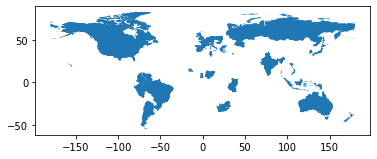

In [64]:
s['geometry'] = [shapely.wkt.loads(x) for x in s['geometry']]
    # add into GeoDataFrame 
s = gpd.GeoDataFrame(s).reset_index(drop=True)
s.plot()

In [66]:
s.to_file("/Users/natalie_kraft/Desktop/testing_pew.geojson", driver='GeoJSON')

In [129]:
j = requests.get("https://www.geoboundaries.org/api/current/gbOpen/RUS/ADM1")

In [132]:
path = j.json()['gjDownloadURL']
shape = requests.get(path).json()

In [143]:
d = pd.read_json(path)

In [160]:
pd.json_normalize(
    shape, 
    record_path = ['features'])

,type,geometry.type,geometry.coordinates,properties.shapeName,properties.Level,properties.shapeISO,properties.shapeID,properties.shapeGroup,properties.shapeType
0,Feature,Polygon,"[[[85.1159569, 54.43783], [85.0334526, 54.4089...",Altai Krai,ADM1,RU-ALT,RUS-ADM1-28173009B49567218,RUS,ADM1
1,Feature,MultiPolygon,"[[[[42.442326, 54.8253986], [42.4073558, 54.84...",Republic of Mordovia,ADM1,RU-MO,RUS-ADM1-28173009B40201491,RUS,ADM1
2,Feature,Polygon,"[[[37.2687091, 54.8418015], [37.2565636, 54.83...",Tula Oblast,ADM1,RU-TUL,RUS-ADM1-28173009B92489997,RUS,ADM1
3,Feature,Polygon,"[[[62.0610577, 56.1308206], [62.070083, 56.129...",Kurgan Oblast,ADM1,RU-KGN,RUS-ADM1-28173009B91354212,RUS,ADM1
4,Feature,Polygon,"[[[44.8479393, 43.5655338], [44.8277321, 43.55...",Ingushetia,ADM1,RU-IN,RUS-ADM1-28173009B89166101,RUS,ADM1
...,...,...,...,...,...,...,...,...,...
78,Feature,MultiPolygon,"[[[[47.6840096, 43.9085911], [47.6834087, 43.9...",Dagestan,ADM1,RU-DA,RUS-ADM1-28173009B43574749,RUS,ADM1
79,Feature,MultiPolygon,"[[[[19.648615891827397, 54.4532277146658], [19...",Kaliningrad,ADM1,RU-KGD,RUS-ADM1-28173009B12217295,RUS,ADM1
80,Feature,Polygon,"[[[50.7681628, 51.7730366], [50.871413, 51.753...",Orenburg Oblast,ADM1,RU-ORE,RUS-ADM1-28173009B57910928,RUS,ADM1
81,Feature,MultiPolygon,"[[[[132.4063493, 44.545623], [132.4066543, 44....",Primorsky Krai,ADM1,RU-PRI,RUS-ADM1-28173009B5071071,RUS,ADM1


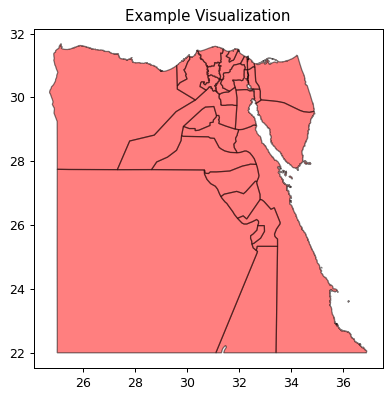

In [58]:
from matplotlib import pyplot as plt
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO=EGY&ADM=ADM1")
dlPath = r.json()[0]['gjDownloadURL']
geoBoundary = requests.get(dlPath).json()

#Matplotlib Visualization
fig = plt.figure(1, figsize=(5,5), dpi=90)
axs = fig.add_subplot(111)
axs.set_title('Example Visualization')

#Accounting for Multipolygon Boundaries
for boundary in geoBoundary["features"]:
    if boundary["geometry"]['type'] == "MultiPolygon":
        polys = boundary["geometry"]["coordinates"]
        for poly in polys:
            exterior = poly[0]
            xs, ys = zip(*exterior)
            axs.fill(xs, ys, alpha=0.5, fc='red', ec='black')
    else:
        exterior = boundary["geometry"]["coordinates"][0]
        xs, ys = zip(*exterior)
        axs.fill(xs, ys, alpha=0.5, fc='red', ec='black')


In [16]:
regions = pd.read_csv("../../data_final/regions.csv")

In [18]:
regions

,name,id,country,geometry,country_id
0,"53195.0, near Kayes, ML",1,Angola,MULTIPOLYGON (((13.46531425195922 -9.171016905...,96
1,"65750.0, near Sikasso, ML",2,Angola,MULTIPOLYGON (((11.84767537747439 -5.149094543...,96
2,"65754.0, near Louga, SN",3,Angola,MULTIPOLYGON (((13.52942308229029 -16.23642797...,96
3,"67417.0, near Sikasso, ML",4,Angola,MULTIPOLYGON (((11.84767537747439 -5.149094543...,96
4,"73552.0, near Koulikoro, ML",5,Angola,"MULTIPOLYGON (((13.7877167 -8.992844399999999,...",96
...,...,...,...,...,...
314,"Trinidad, Couva-Tabaquite-Talparo, Trinidad an...",1,Trinidad and Tobago,"POLYGON ((-61.9308275 10.0517423, -61.9307846 ...",66
315,"A, Road Leading to House, Tharaka-Nithi, East ...",2,Kenya,"POLYGON ((37.7013015 -0.3216591, 37.701303 -0....",103
316,Zambezi Region,8,Namibia,"POLYGON ((22.5000204 -18.1175994, 22.629244 -1...",108
317,"Lake Turkana, Marsabit, East Kenya",3,Kenya,"POLYGON ((35.8291411 3.7150324, 35.8291519 3.7...",103
